Recurrent Neural Networks for Sentiment Analysis. We will use the Product Reviews dataset which has around 25000 customer reviews. Our end goal will be to give a rating according to the review given.

### Sentiment Analysis using RNN
Sentiment Analysis is the process of extracting information from the texts. It involves various steps of Natural Language Processing like, text cleaning, text vectorization, stemming, lemmatization, and many more. We will use the above mentioned steps to finally generate a model that can give rating predictions to the reviews.

Recurrent Neural Networks are a type of neural network which uses previous information to give output. We will use RNN with different setups to get maximum accuracy. Further, we will also use LSTM (Long Short Term Memory) which is an extension to RNN, to further increase the accuracy.

### Dataset
We’ve used the dataset i.e. Consumer Reviews of Products. The dataset contains information like reviews and ratings.

### Step 1: Importing necessary Libraries



In [ ]:
pip install pandas

In [ ]:
pip install seaborn

In [ ]:
pip install nltk

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import tensorflow as tf
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Dropout, Embedding, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences

import warnings
warnings.filterwarnings('ignore')


### Step 2: Loading the dataset
The Amazon dataset contains 25000 customer reviews on Amazon products. Here is how we can load the dataset and get information on it.


In [ ]:
data = pd.read_csv('AmazonReview.csv')

# Printing shape of the dataset
print(data.shape)
# printing columns and rows information
print(data.info())


(25000, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Review     24999 non-null  object
 1   Sentiment  25000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 390.8+ KB
None


From the above output, we can see that the dataset is of the shape (25000, 2), which shows that it has 25000 rows and 2 columns.

# Step 3: Exploratory Data Analysis
1. As we’ve to just get a sentiment analysis of reviews, so let’s extract useful information from the dataset. Also, let’s look at how many null values are present in this dataset.

In [ ]:
# looking for NULL values
print("Null Values:\n", data.isna().sum())

# dropping null values
data = data.dropna()

# again checking for NULL values
print("Null Values after dropping:\n", data.isna().sum())


Null Values:
 Review       1
Sentiment    0
dtype: int64
Null Values after dropping:
 Review       0
Sentiment    0
dtype: int64


Let’s take a look at the number of values of each unique item in the Sentiment column.

In [ ]:
# count of unique values in Sentiment column
data['Sentiment'].value_counts()


,count
Sentiment,
1,5000
2,5000
3,5000
4,5000
5,4999


### 2. Text Cleaning: In this step, we will clean the ‘reviews.text’ column. We will remove the unwanted HTML tags, brackets, or special characters that may be present in the texts. We will use Regex to clean the text.

In [ ]:
import nltk
nltk.download('punkt')  # Make sure to run this line once to download the tokenizer
nltk.download('punkt_tab')  # Make sure to run this line once to download the tokenizer


print(nltk.data.find('tokenizers/punkt'))

/root/nltk_data/tokenizers/punkt


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Download required NLTK resources
nltk.download('punkt')
nltk.download('punkt_tab')       # <-- sometimes needed for new NLTK versions
nltk.download('stopwords')

# Define stop words
stop_words = set(stopwords.words('english'))

# Function to clean reviews
def clean_reviews(text):
    if isinstance(text, str):
        text = text.lower()
        text = word_tokenize(text)
        text = [word for word in text if word not in stop_words]
    else:
        text = []
    return text

# Ensure text column is clean
data['Review'] = data['Review'].astype(str)
data['Review'] = data['Review'].fillna('')

# Apply cleaning function
data['Review'] = data['Review'].apply(clean_reviews)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 4. Tokenization & Text Encoding: In this step, we will use tokenization to first generate the tokens. For this, we will use Tokenizer from the Tensorflow library. And we will encode the text using the same.

We have around 5 unique values in the ‘reviews.rating’ column. So let’s use one-hot encoding to represent each value in the rating as separate columns.

Also, in this step, we have initialized X(input) and y(output) to the model.

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import pandas as pd

# Initialize the tokenizer
tokenizer = Tokenizer()

# Convert all the reviews to a list to pass it as a parameter to fit_on_texts
reviews_to_list = data['Review'].tolist()
tokenizer.fit_on_texts(reviews_to_list)

# Generate text sequences (list of lists)
text_sequences = tokenizer.texts_to_sequences(reviews_to_list)

# Set the maximum number of words in a sequence
max_words = 500

# Pad sequences to ensure they all have the same length
X = pad_sequences(text_sequences, maxlen=max_words)

# Check if 'Sentiment' column still exists before processing it
if 'Sentiment' in data.columns:
    # Convert 'Sentiment' column to integer type before one-hot encoding
    # This ensures dummy column names are 'Sentiment_1', 'Sentiment_2', etc.
    data['Sentiment'] = data['Sentiment'].astype(int)

    # One hot encoding the Sentiment column
    data = pd.get_dummies(data, columns=['Sentiment'])
elif 'Sentiment_1.0' in data.columns and 'Sentiment_1' not in data.columns:
    # If 'Sentiment' is gone but 'Sentiment_1.0' exists, rename it to 'Sentiment_1'
    # This handles the case where get_dummies already ran with float values
    data = data.rename(columns={'Sentiment_1.0': 'Sentiment_1'})

# Define the expected output columns for y (Sentiment_1 to Sentiment_5)
expected_sentiment_cols = ['Sentiment_1', 'Sentiment_2', 'Sentiment_3', 'Sentiment_4', 'Sentiment_5']

# Generate the output labels y
# Reindex 'data' to ensure all expected columns are present, filling missing with 0
y = data.reindex(columns=expected_sentiment_cols, fill_value=0)

# Convert y to integer type to ensure compatibility with TensorFlow
y = y.astype(int)

# Print the shapes of X and y
print(X.shape, y.shape)

(24999, 500) (24999, 5)


### 5. Train-Test Split: In this step, we will split our dataset into training and testing datasets. We will split the dataset into 80-20%, i.e. 80% for the training and 20% for testing.

In [ ]:
pip install scikit-learn

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
# The tokenizer and padding steps are already performed in the previous cell
# and X and y are already available in the global scope.

# Train Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Print the shapes of the training and testing sets
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(19999, 500) (5000, 500) (19999, 5) (5000, 5)


### Step 4: Model Building, Compiling andLet’s Training

### 1. Build the Model: In this step, let’s build our model using RNN.



In [ ]:
# Creating a RNN model
rnn = Sequential(name="Simple_RNN")
rnn.add(Embedding(len(tokenizer.word_index)+1,
						max_words,
						input_length=max_words))

rnn.add(SimpleRNN(128,activation='tanh',return_sequences=True))

rnn.add(SimpleRNN(64,activation='tanh',return_sequences=False))

rnn.add(Dense(5, activation='softmax'))

# printing model summary
print(rnn.summary())

Model: "Simple_RNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_4 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_5 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


### 2. Compiling the model and Model Evaluation: Let’s compile and train the model we defined in the above step. Then we will see the accuracy of the model on the test dataset.

In [ ]:
# Compiling model
rnn.compile(
	loss="categorical_crossentropy",
	optimizer='adam',
	metrics=['accuracy']
)

# Ensure y_train and y_test are of integer type
y_train_int = y_train.astype(int)
y_test_int = y_test.astype(int)

# Training the model
history = rnn.fit(X_train, y_train_int,
						batch_size=64,
						epochs=2,
						verbose=1,
						validation_data = (X_test, y_test_int))

# Printing model score on test data
print("Simple_RNN Score---> ", rnn.evaluate(X_test, y_test_int, verbose=1))

Epoch 1/2
313/313 ━━━━━━━━━━━━━━━━━━━━ 50s 127ms/step - accuracy: 0.2361 - loss: 1.6149 - val_accuracy: 0.3532 - val_loss: 1.4291
Epoch 2/2
313/313 ━━━━━━━━━━━━━━━━━━━━ 29s 93ms/step - accuracy: 0.5374 - loss: 1.1509 - val_accuracy: 0.4022 - val_loss: 1.4067
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.3925 - loss: 1.4138
Simple_RNN Score--->  [1.4066942930221558, 0.40220001339912415]


Text(0, 0.5, 'Loss')

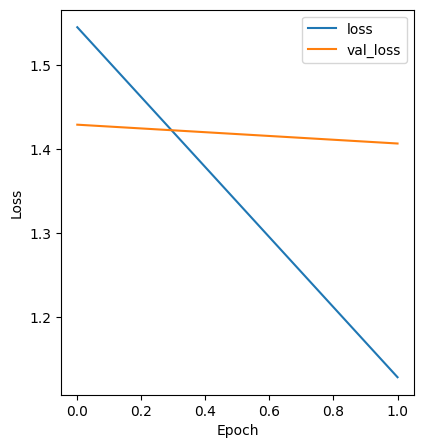

In [ ]:
metrics = history.history
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')



Text(0, 0.5, 'Accuracy')

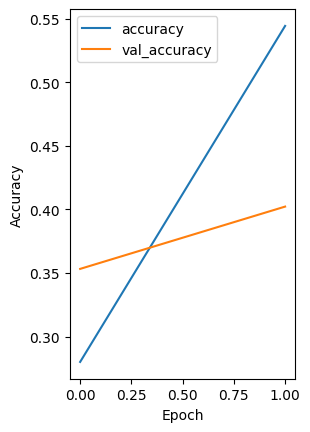

In [ ]:
# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')


Thus we’ve got an accuracy of 40% while using RNN.
## LSTM ( Long Short Term Memory)
Let’s use LSTM and see how the model performance is changing. We will simply start with defining the model, compiling and then training. To understand the theoretical aspects of LSTM please visit this article Long Short Term Memory Networks Explanation.

In [ ]:
model = Sequential(name="LSTM_Model")
model.add(Embedding(len(tokenizer.word_index)+1,
					max_words,
					input_length=max_words))

# adding a LSTM layer
model.add(LSTM(150, return_sequences=False))
BatchNormalization()
model.add(Dropout(0.5))

#adding a dense layer with activation function of relu
model.add(Dense(50, activation='relu'))
BatchNormalization()
model.add(Dropout(0.5))

# adding the final output activation with activation function of softmax
model.add(Dense(5, activation='softmax'))

# printing model summary
print(model.summary())


Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenize and limit the vocabulary size
tokenizer = Tokenizer(num_words=5000)
reviews_to_list = data['Review'].tolist()
tokenizer.fit_on_texts(reviews_to_list)
text_sequences = tokenizer.texts_to_sequences(reviews_to_list)

# Determine vocabulary size (if not limiting)
vocab_size = len(tokenizer.word_index) + 1  # Consider increasing this if needed

# Padding sequences
X = pad_sequences(text_sequences, maxlen=500)

# Define the model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=500))
model.add(GRU(units=128, return_sequences=False))
model.add(Dense(units=5, activation='softmax'))

# Compile the model
model.compile(
    loss="categorical_crossentropy",
    optimizer='adam',
    metrics=['accuracy']
)

# Train the model
history = model.fit(X_train, y_train,
                    batch_size=64,
                    epochs=3,
                    verbose=1,
                    validation_data=(X_test, y_test))

# Evaluate the model
print("GRU model Score---> ", model.evaluate(X_test, y_test, verbose=1))


Epoch 1/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - accuracy: 0.2978 - loss: 1.5413 - val_accuracy: 0.3902 - val_loss: 1.3615
Epoch 2/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.5001 - loss: 1.1878 - val_accuracy: 0.4604 - val_loss: 1.2094
Epoch 3/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.6290 - loss: 0.9210 - val_accuracy: 0.4622 - val_loss: 1.2816
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.4564 - loss: 1.2873
GRU model Score--->  [1.2815550565719604, 0.46219998598098755]


Thus we got the final accuracy of 48% using LSTM. Let’s take a look at the classification report of this LSTM model.

### Classification Report

Text(0, 0.5, 'Accuracy')

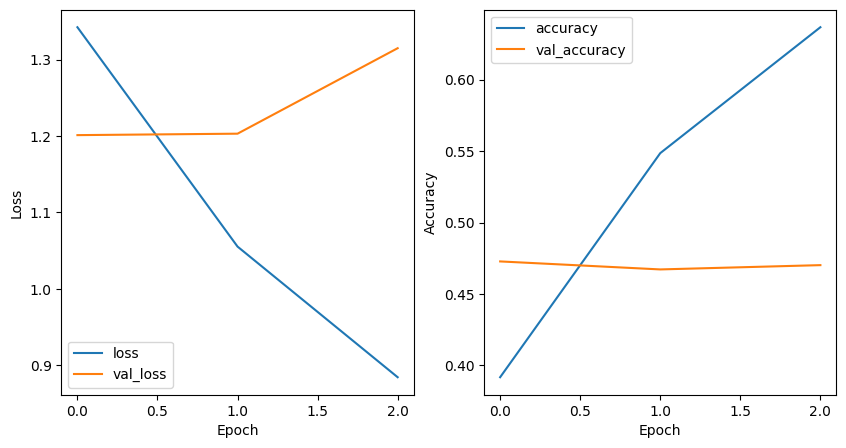

In [ ]:
# Plotting the history
metrics = history.history
plt.figure(figsize=(10, 5))

# Plotting training and validation loss
plt.subplot(1, 2, 1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.epoch, metrics['accuracy'],
		metrics['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')


157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


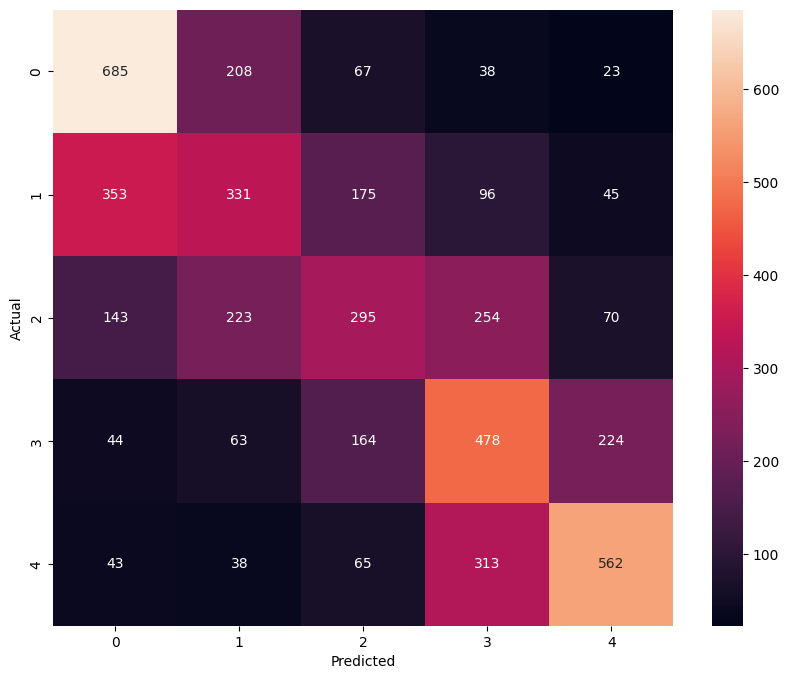

In [ ]:
# converting y_test tht was one hot encoded to one column fo rconfusion matrix
y_true = np.argmax(y_test.values, axis=1)
y_true.shape

# Confusion matrix
y_pred = np.argmax(model.predict(X_test), axis=1)
cm = tf.math.confusion_matrix(y_true, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [ ]:
from sklearn.metrics import classification_report
report = classification_report(y_true, y_pred)
print(report)


              precision    recall  f1-score   support

           0       0.54      0.67      0.60      1021
           1       0.38      0.33      0.36      1000
           2       0.39      0.30      0.34       985
           3       0.41      0.49      0.44       973
           4       0.61      0.55      0.58      1021

    accuracy                           0.47      5000
   macro avg       0.46      0.47      0.46      5000
weighted avg       0.47      0.47      0.46      5000



### Testing the trained model
Let’s take a look at how the model is performing on the text we give in. For this make a custom function in which we will pass out text and it will generate the rating using the model.

In [ ]:
def predict_review_rating(text):
    # Tokenize the input text
    text_sequences_test = tokenizer.texts_to_sequences([text])

    # Pad the sequence to ensure it matches the input length expected by the model
    testing = pad_sequences(text_sequences_test, maxlen=max_words)

    # Predict the rating (output class) using the trained model
    y_pred_test = np.argmax(model.predict(testing), axis=1)

    # Return the predicted rating
    return y_pred_test[0] + 1

# Testing the prediction function
rating1 = predict_review_rating('Worst product')
print("The rating according to the review is: ", rating1)

rating2 = predict_review_rating('Awesome product, I will recommend this to other users.')
print("The rating according to the review is: ", rating2)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
The rating according to the review is:  1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
The rating according to the review is:  5
